# Principal Component Analysis As A Factor Model

## Introduction
...**To Do**

Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt

Magic

In [2]:
%matplotlib inline

## Data Collection

Set keys

In [3]:
keys = ['sp500',
        'sp400',
        'sp600']

Initialize S&P Indices close data

In [4]:
close = {}

Update S&P Indices close data

In [5]:
for i in keys: 
    # Load OHLCV data
    with open(i + '_data.pickle', 'rb') as f:
        data = pickle.load(f)
    
    # Update close prices data
    close[i] = data.close.loc['2014-06-11':]
    
    # Close file
    f.close

Inspect S&P 500 index constituents data

In [6]:
close['sp500'].head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,40.1199,40.2868,125.0694,86.0249,45.0769,66.4223,22.92,35.9633,74.9719,67.46,...,25.6691,40.9150,84.1321,46.6073,28.8084,35.4555,51.7899,101.5068,28.0164,30.9798
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031,65.9975,23.03,35.7925,74.5018,66.56,...,25.8547,41.1019,83.8928,46.4230,28.5372,35.2780,51.2950,101.0367,27.7535,30.8448
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187,66.2930,22.95,35.7745,74.7820,66.82,...,25.8884,41.6091,84.7098,46.3744,28.4920,36.0532,51.5945,101.2861,27.8192,30.9702
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857,66.0529,23.27,35.8734,74.8634,67.62,...,26.0740,41.9028,84.9326,46.4424,28.3791,35.9318,51.5099,100.7105,27.4060,30.9798
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351,66.2561,23.43,35.8375,74.5832,67.54,...,26.0910,42.2409,84.5200,46.2677,28.8310,36.0346,51.7639,100.4707,27.9601,31.6355


In [7]:
close['sp500'].tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,67.95,29.12,154.61,179.64,76.75,82.21,267.06,77.46,177.97,268.71,...,57.78,106.90,73.59,54.40,33.30,77.40,106.97,117.41,44.40,108.12
2019-06-05,68.35,30.36,154.61,182.54,77.06,81.65,268.80,78.69,179.56,272.86,...,59.32,105.60,72.98,55.38,33.42,78.88,107.29,118.54,44.18,108.50
2019-06-06,69.16,30.38,154.90,185.22,77.07,81.75,269.19,80.09,180.40,274.80,...,59.80,106.01,74.31,55.63,34.03,79.15,108.42,120.31,44.24,108.89
2019-06-07,69.52,30.92,155.35,190.15,77.43,83.48,267.87,80.74,182.92,278.16,...,59.43,107.49,74.58,55.94,34.16,79.56,109.07,120.73,43.64,110.06
2019-06-10,70.29,30.76,153.52,192.58,76.95,84.77,272.43,81.27,184.44,280.34,...,59.26,110.88,74.91,57.10,34.69,80.38,108.65,121.71,43.84,110.22


In [8]:
close['sp500'].describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,52.010924,41.207727,145.418612,135.094399,66.653293,84.553883,162.741109,49.113396,118.473403,142.243243,...,39.351443,58.850843,75.442714,53.174206,26.877544,51.296575,66.602743,111.697803,36.704361,59.798250
std,13.866577,6.366236,24.128339,38.127616,17.721243,9.483389,116.577717,12.653128,31.189929,70.413470,...,8.322974,22.240068,4.717698,7.833835,3.222176,16.349757,15.997628,9.929764,10.736900,20.223068
min,32.258600,24.539800,79.168700,82.743800,42.066600,65.718100,22.220000,33.935700,68.852300,60.880000,...,25.247700,32.502600,58.967500,34.178400,18.532600,28.874500,44.181800,89.236100,18.885300,30.652000
25%,39.393500,36.586125,132.519725,103.622650,53.170800,77.738125,80.662500,39.405975,92.616475,82.092500,...,31.485800,42.102950,72.534125,48.731800,24.215550,35.033175,53.060925,103.343675,26.826025,44.749325
50%,46.097600,40.843300,150.457700,119.473800,58.470800,83.840300,118.550000,43.040600,112.097050,107.945000,...,39.055650,52.368850,75.817000,54.521200,26.573400,48.085300,61.564200,112.761500,38.198900,51.333600
75%,65.591850,46.119900,161.899875,167.841200,82.894300,89.847025,261.935000,58.171250,149.591750,212.247500,...,45.444750,68.789375,78.491000,59.650550,29.650500,67.341800,80.202225,119.131625,46.431025,80.809150
max,81.940000,57.586600,199.159900,229.392000,116.445400,107.649700,449.750000,81.270000,184.440000,289.250000,...,59.800000,139.263300,86.137400,67.795300,35.000000,83.549000,109.070000,130.912800,57.139500,110.220000


In [9]:
close['sp500'].shape

(1258, 505)

Fill NaNs with last observation 

In [12]:
close['sp500'].fillna(method='ffill', inplace=True)

In [13]:
close['sp400'].fillna(method='ffill', inplace=True)

In [14]:
close['sp600'].fillna(method='ffill', inplace=True)

Count the number of NaNs per S&P Index

In [15]:
sum([close['sp500'].isna()]).sum(axis='columns').sum('rows')

13327.0

In [16]:
sum([close['sp400'].isna()]).sum(axis='columns').sum('rows')

15066.0

In [17]:
sum([close['sp600'].isna()]).sum(axis='columns').sum('rows')

22353.0

Initialize daily returns

In [18]:
returns = {}

Calculate daily returns

In [19]:
for i in keys:
    # Update returns 
    returns[i] = close[i].pct_change()

Inspect S&P 500 Index constituents' returns

In [20]:
returns['sp500'].head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-12,-0.008657,-0.049421,-0.014745,-0.016727,-0.010511,-0.006395,0.004799,-0.004749,-0.006270,-0.013341,...,0.007230,0.004568,-0.002844,-0.003954,-0.009414,-0.005006,-0.009556,-0.004631,-0.009384,-0.004358
2014-06-13,0.001712,0.004476,0.004183,-0.010944,0.009318,0.004477,-0.003474,-0.000503,0.003761,0.003906,...,0.001303,0.012340,0.009739,-0.001047,-0.001584,0.021974,0.005839,0.002468,0.002367,0.004066
2014-06-16,-0.003077,0.016840,0.002165,0.010079,-0.002954,-0.003622,0.013943,0.002765,0.001088,0.011972,...,0.007169,0.007059,0.002630,0.001466,-0.003963,-0.003367,-0.001640,-0.005683,-0.014853,0.000310
2014-06-17,0.009431,0.019729,0.007520,-0.001302,0.005556,0.003076,0.006876,-0.001001,-0.003743,-0.001183,...,0.000652,0.008069,-0.004858,-0.003762,0.015924,0.002861,0.004931,-0.002381,0.020218,0.021165


In [21]:
returns['sp500'].tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,0.014330,0.070588,0.009401,0.036584,0.013871,0.022894,0.021535,0.023115,0.016042,0.037370,...,-0.002934,0.044966,0.023790,0.010026,0.074887,0.022187,0.027471,0.027209,0.024931,0.040115
2019-06-05,0.005887,0.042582,0.000000,0.016143,0.004039,-0.006812,0.006515,0.015879,0.008934,0.015444,...,0.026653,-0.012161,-0.008289,0.018015,0.003604,0.019121,0.002991,0.009624,-0.004955,0.003515
2019-06-06,0.011851,0.000659,0.001876,0.014682,0.000130,0.001225,0.001451,0.017791,0.004678,0.007110,...,0.008092,0.003883,0.018224,0.004514,0.018253,0.003423,0.010532,0.014932,0.001358,0.003594
2019-06-07,0.005205,0.017775,0.002905,0.026617,0.004671,0.021162,-0.004904,0.008116,0.013969,0.012227,...,-0.006187,0.013961,0.003633,0.005573,0.003820,0.005180,0.005995,0.003491,-0.013562,0.010745
2019-06-10,0.011076,-0.005175,-0.011780,0.012779,-0.006199,0.015453,0.017023,0.006564,0.008310,0.007837,...,-0.002861,0.031538,0.004425,0.020737,0.015515,0.010307,-0.003851,0.008117,0.004583,0.001454


In [22]:
returns['sp500'].describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,...,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.000552,0.000053,0.000396,0.000762,0.000579,0.000326,0.002353,0.000733,0.000791,0.001274,...,0.000719,0.000975,-0.000021,0.000273,0.000317,0.000740,0.000686,0.000239,0.000494,0.001114
std,0.014523,0.023120,0.021484,0.015541,0.017527,0.016218,0.027687,0.012973,0.012195,0.016763,...,0.010323,0.019046,0.011927,0.014862,0.018415,0.013338,0.013731,0.013735,0.016609,0.014400
min,-0.110117,-0.108143,-0.222986,-0.099607,-0.127612,-0.130314,-0.285859,-0.092907,-0.072826,-0.082909,...,-0.049252,-0.170770,-0.056903,-0.186519,-0.133393,-0.062237,-0.188324,-0.139943,-0.101920,-0.122064
25%,-0.006582,-0.012345,-0.007862,-0.006164,-0.007352,-0.006508,-0.008460,-0.005453,-0.004824,-0.005894,...,-0.005130,-0.007360,-0.006192,-0.006693,-0.008064,-0.006040,-0.004791,-0.006326,-0.009010,-0.005760
50%,0.000755,0.000240,0.000378,0.000627,0.001135,0.001078,0.001647,0.000688,0.001090,0.001354,...,0.001094,0.001031,0.000117,0.000679,0.000689,0.000615,0.001020,0.000393,0.000903,0.001077
75%,0.008832,0.012946,0.009072,0.008638,0.008567,0.008426,0.014375,0.008247,0.006941,0.009629,...,0.007230,0.009315,0.006150,0.007705,0.009464,0.008557,0.006628,0.007593,0.010318,0.008096
max,0.078422,0.112325,0.216794,0.070421,0.137673,0.112491,0.292778,0.061928,0.067566,0.122418,...,0.033668,0.184365,0.055159,0.176482,0.198259,0.093246,0.069101,0.077619,0.068521,0.114061


In [23]:
returns['sp500'].shape

(1258, 505)

## Momentum Strategy Implementation
1. PCA
2. OLS
3. Momentum

...**To Do**

### Set Parameters
...**To Do**

Lookback period

In [24]:
lookback = 250

Number of factors 

In [25]:
number_of_factors = 5

Top n stocks

In [26]:
top_n = 50

### Principal Component Analysis (PCA)
...**To Do**

### Ordinary Least Squares (OLS)
...**To Do**

### Momentum Strategy
...**To Do**

Initialize positions

In [27]:
positions = {}

for i in keys:
    # Update positions
    positions[i] = pd.DataFrame(np.zeros((returns[i].shape[0], returns[i].shape[1])),
                                 index=returns[i].index,
                                 columns=returns[i].columns
                                )

Momentum strategy

In [28]:
for i in keys:
    for j in range(lookback + 1, len(close[i])):
        # Calculate the daily returns
        R = returns[i].iloc[j - lookback + 1:j, :]

        # Avoid daily returns with NaNs
        has_data = (R.count() == max(R.count()))
        has_data_list = list(R.columns[has_data])
        R = R.loc[:, has_data_list]

        # Calculate the mean of the daily returns
        R_mean = R.mean()

        # Calculate the adjusted daily returns
        R_adj = R.sub(R_mean)

        # Calculate the covariance matrix
        cov = R_adj.cov()

        # Calculate the eigenvalues (B) and eigenvectors (X)
        eigen = np.linalg.eig(cov)
        B = eigen[0]
        X = eigen[1]

        # Retain only a number of factors
        X = X[:, :number_of_factors]

        # OLS
        model = sm.OLS(R_adj.iloc[-1], X)
        results = model.fit()
        b = results.params

        # Calculate the expected returns
        R_exp = R_mean.add(np.matmul(X, b))

        # Momentum strategy
        shorts = R_exp.sort_values()[:top_n].index
        positions[i].iloc[j][shorts] = -1
        longs = R_exp.sort_values()[-top_n:].index
        positions[i].iloc[j][longs] = 1

## Performance Analysis
1. Sharpe Ratio
2. Maximum Drawdown

...**To Do**

Adjust positions

In [30]:
for i in keys:
    positions[i] = positions[i].shift(periods=1)

Compute the daily returns of the momentum strategy

In [31]:
returns_strat = {}
returns_strat_avg = {}

for i in keys:
    # Daily returns
    returns_strat[i] = (positions[i].mul(returns[i])).sum(axis='columns')
    # Annualized average returns of the momentum strategy
    returns_strat_avg[i] = returns_strat[i].mean() * 250

In [32]:
returns_strat_avg['sp500']

-0.12404414155112715

In [33]:
returns_strat_avg['sp400']

-0.5999727971650718

In [34]:
returns_strat_avg['sp600']

-2.0378186524235113

Plot the cumulative PnL

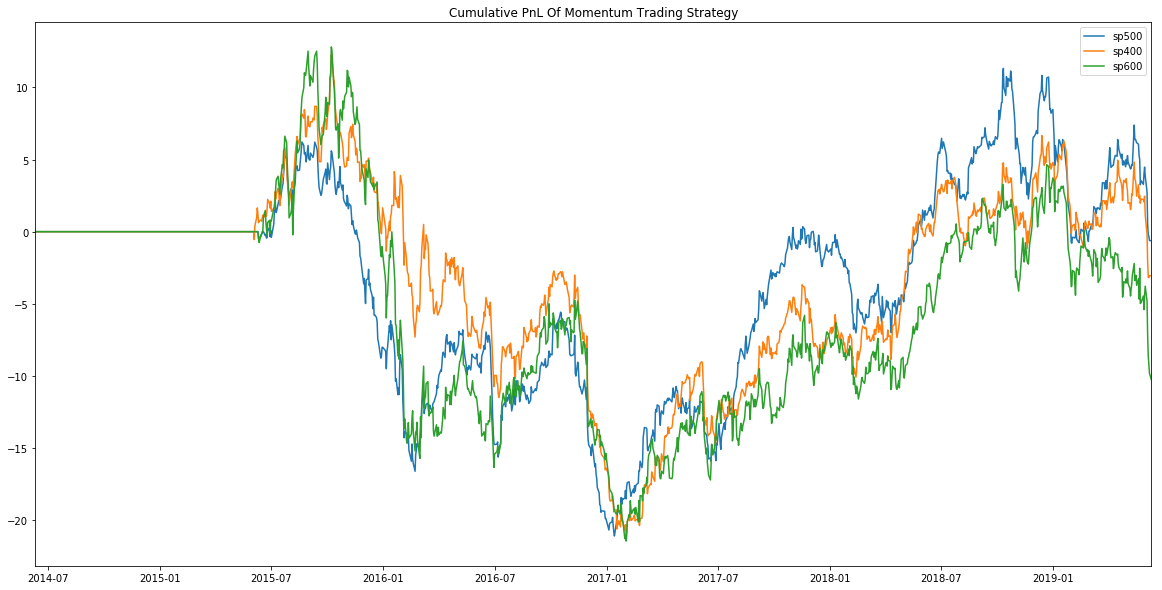

In [35]:
# Set size 
plt.figure(figsize=(20, 10))

for i in range(len(keys)):
    plt.plot(returns_strat[keys[i]].cumsum())

plt.xlim(returns_strat['sp500'].index[0], returns_strat['sp500'].index[-1])    

# Set title and legend
plt.title('Cumulative PnL Of Momentum Trading Strategy')
plt.legend(keys)

## Conclusion
...**To Do**